In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score

import keras
import keras.backend as K
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation

plt.style.use('ggplot')
%matplotlib inline 

In [2]:
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [3]:
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
train_df.shape

(20631, 26)

In [5]:
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [6]:
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


In [7]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [8]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [10]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()

norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [11]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [12]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL 
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 , w1
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


In [13]:
# window size:50 cycles
sequence_length = 50

In [14]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [15]:
# feature
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [16]:
# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

142


In [17]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

seq_gen

<generator object <genexpr> at 0x7fcffc1504a0>

In [18]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape


(15631, 50, 25)

In [19]:
# function to generate labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
  
    return data_matrix[seq_length:num_elements, :]


In [20]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(15631, 1)

In [21]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [22]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [23]:
model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
____________________________________________________

In [24]:
model_path = 'regression_model.h5'

history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Epoch 1/100
75/75 - 36s - loss: 8840.0801 - mae: 75.3172 - r2_keras: -1.7354e+00 - val_loss: 8264.2119 - val_mae: 72.4908 - val_r2_keras: -2.4777e+00
Epoch 2/100
75/75 - 17s - loss: 8181.3413 - mae: 71.5095 - r2_keras: -1.5195e+00 - val_loss: 7744.8022 - val_mae: 69.4715 - val_r2_keras: -2.2322e+00
Epoch 3/100
75/75 - 15s - loss: 7660.2529 - mae: 68.5061 - r2_keras: -1.3616e+00 - val_loss: 7242.8599 - val_mae: 66.5701 - val_r2_keras: -1.9969e+00
Epoch 4/100
75/75 - 15s - loss: 7176.9673 - mae: 65.7247 - r2_keras: -1.2167e+00 - val_loss: 6773.4590 - val_mae: 63.8741 - val_r2_keras: -1.7788e+00
Epoch 5/100
75/75 - 17s - loss: 6722.0815 - mae: 63.1491 - r2_keras: -1.0687e+00 - val_loss: 6336.3125 - val_mae: 61.3838 - val_r2_keras: -1.5777e+00
Epoch 6/100
75/75 - 15s - loss: 6288.9399 - mae: 60.7240 - r2_keras: -9.3138e-01 - val_loss: 5924.3311 - val_mae: 59.0559 - val_r2_keras: -1.3905e+00
Epoch 7/100
75/75 - 17s - loss: 5891.3101 - mae: 58.4774 - r2_keras: -8.1217e-01 - val_loss: 5543.00

Epoch 58/100
75/75 - 27s - loss: 615.5083 - mae: 15.7938 - r2_keras: 0.8124 - val_loss: 1144.3826 - val_mae: 19.5018 - val_r2_keras: 0.6170
Epoch 59/100
75/75 - 16s - loss: 594.1443 - mae: 15.5122 - r2_keras: 0.8181 - val_loss: 1179.0023 - val_mae: 20.5993 - val_r2_keras: 0.4520
Epoch 60/100
75/75 - 20s - loss: 576.5947 - mae: 15.2898 - r2_keras: 0.8232 - val_loss: 1127.8192 - val_mae: 20.3804 - val_r2_keras: 0.5161
Epoch 61/100
75/75 - 18s - loss: 574.3219 - mae: 15.3224 - r2_keras: 0.8244 - val_loss: 1285.1923 - val_mae: 18.3704 - val_r2_keras: 0.5663
Epoch 62/100
75/75 - 19s - loss: 549.9952 - mae: 15.0127 - r2_keras: 0.8327 - val_loss: 1230.8542 - val_mae: 21.7196 - val_r2_keras: 0.3814
Epoch 63/100
75/75 - 18s - loss: 541.0043 - mae: 14.8913 - r2_keras: 0.8343 - val_loss: 1375.3059 - val_mae: 23.9112 - val_r2_keras: 0.3338
Epoch 64/100
75/75 - 18s - loss: 542.6904 - mae: 14.8924 - r2_keras: 0.8332 - val_loss: 975.8079 - val_mae: 21.8429 - val_r2_keras: 0.4378
Epoch 65/100
75/75 - 

In [25]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'r2_keras', 'val_loss', 'val_mae', 'val_r2_keras'])


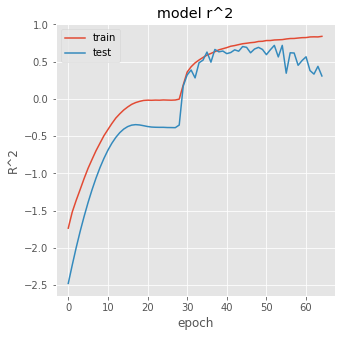

In [26]:
# R^2
import seaborn as sns
fig_acc = plt.figure(figsize=(5, 5))
fig_acc.set_facecolor('white')

plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
fig_acc.savefig("model_r2.png")


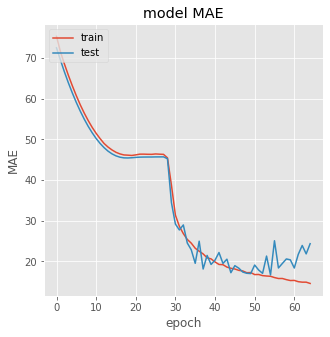

In [27]:
# MAE
fig_acc = plt.figure(figsize=(5, 5))
fig_acc.set_facecolor('white')


plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")


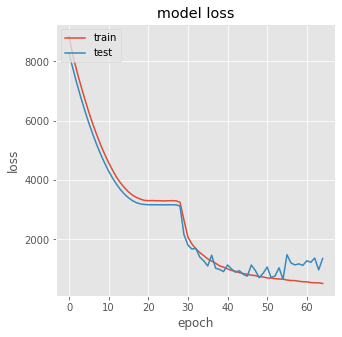

In [28]:
# Loss
fig_acc = plt.figure(figsize=(5, 5))
fig_acc.set_facecolor('white')


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [29]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

79/79 [==============================] - 8s 103ms/step - loss: 520.1138 - mae: 14.0731 - r2_keras: 0.8015

MAE: 14.073065757751465

R^2: 0.8014807105064392


In [30]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

79/79 [==============================] - 9s 89ms/step


In [31]:
import sklearn.metrics as metrics

print(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

22.806004


In [32]:
test_set = pd.DataFrame(y_pred)
test_set.to_csv('regression_submit_train.csv', index = None)


In [33]:
##################################
# EVALUATE ON TEST DATA
##################################


In [34]:
# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")

print(seq_array_test_last.shape)

seq_array_test_last
(93, 50, 25)


In [35]:
# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

(93, 1)
label_array_test_last
[[ 69.]
 [ 82.]
 [ 91.]
 [ 93.]
 [ 91.]
 [ 95.]
 [111.]
 [ 96.]
 [ 97.]
 [124.]
 [ 95.]
 [ 83.]
 [ 84.]
 [ 50.]
 [ 28.]
 [ 87.]
 [ 16.]
 [ 57.]
 [113.]
 [ 20.]
 [119.]
 [ 66.]
 [ 97.]
 [ 90.]
 [115.]
 [  8.]
 [ 48.]
 [106.]
 [  7.]
 [ 11.]
 [ 19.]
 [ 21.]
 [ 50.]
 [ 28.]
 [ 18.]
 [ 10.]
 [ 59.]
 [109.]
 [114.]
 [ 47.]
 [135.]
 [ 92.]
 [ 21.]
 [ 79.]
 [114.]
 [ 29.]
 [ 26.]
 [ 97.]
 [137.]
 [ 15.]
 [103.]
 [ 37.]
 [114.]
 [100.]
 [ 21.]
 [ 54.]
 [ 72.]
 [ 28.]
 [128.]
 [ 14.]
 [ 77.]
 [  8.]
 [121.]
 [ 94.]
 [118.]
 [ 50.]
 [131.]
 [126.]
 [113.]
 [ 10.]
 [ 34.]
 [107.]
 [ 63.]
 [ 90.]
 [  8.]
 [  9.]
 [137.]
 [ 58.]
 [ 89.]
 [116.]
 [115.]
 [136.]
 [ 28.]
 [ 38.]
 [ 20.]
 [ 85.]
 [ 55.]
 [128.]
 [137.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]


In [36]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))

3/3 - 0s - loss: 496.2436 - mae: 14.6348 - r2_keras: 0.7097

MAE: 14.634825706481934

R^2: 0.7096648216247559


In [37]:
# make predictions and compute confusion matrix
y_pred_test = model.predict(seq_array_test_last)
y_true_test = label_array_test_last

In [38]:
print(np.sqrt(metrics.mean_squared_error(y_true_test, y_pred_test)))

22.276527


In [39]:
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

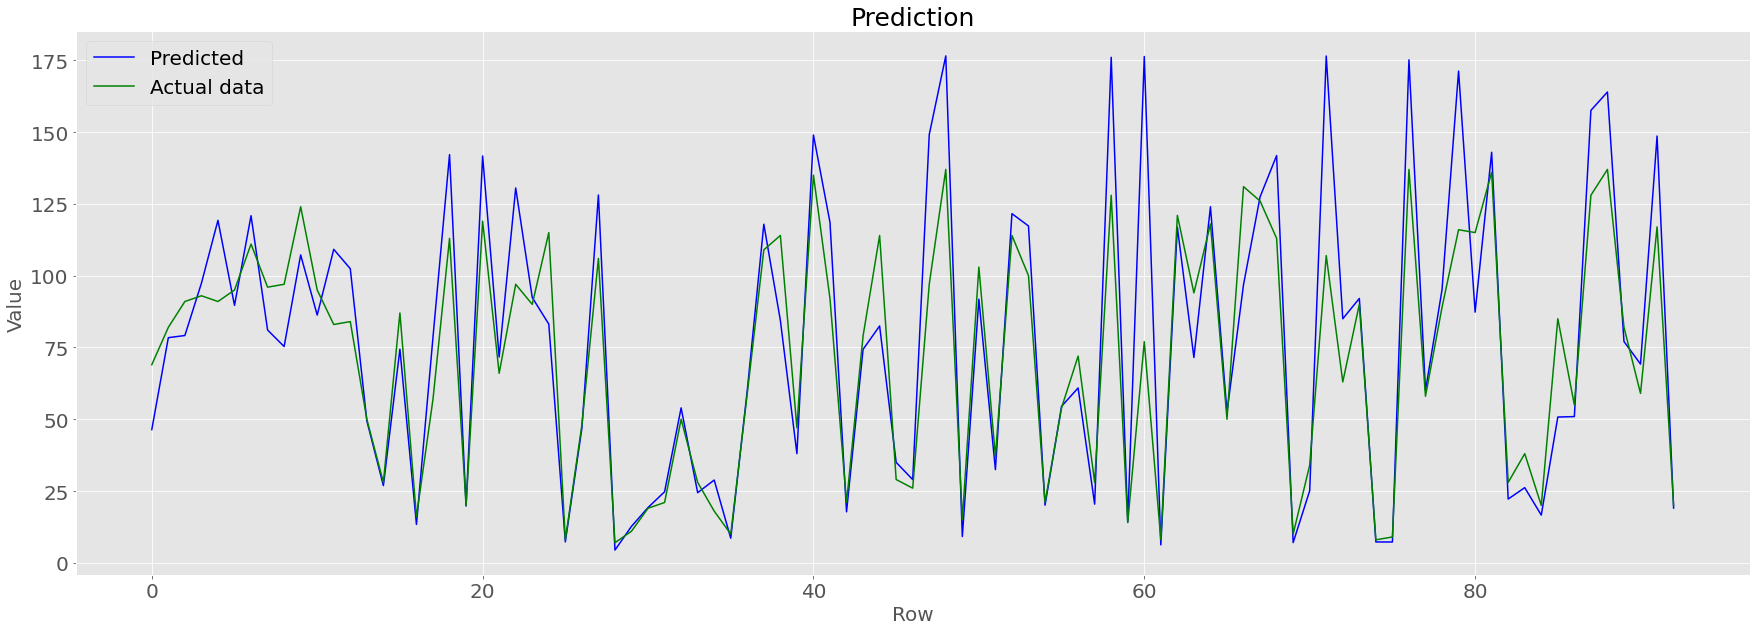

In [40]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.

fig_verify = plt.figure(figsize=(30, 10))
fig_verify.set_facecolor('white')


plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('Prediction', fontsize=25)
plt.ylabel('Value', fontsize=20)
plt.xlabel('Row', fontsize=20)
plt.legend(['Predicted', 'Actual data'], loc='upper left', fontsize= 20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)


parameters = {'axes.labelsize': 35,
          'axes.titlesize': 35,
             'xtick.labelsize': 25,
             'ytick.labelsize':25,
              'legend.title_fontsize':35
             }
plt.rcParams.update(parameters)

plt.show()
fig_verify.savefig('model_regression_verify.png')